This notebook contains the code for the meta-analysis of healthy lung data for ACE2, TMPRSS2, and CTSL. It contains the hold-out analysis for the complex model with interaction terms that was run on the cell-level data. This script contains the code that was run on the full data and does not test for smoking associations.

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib import colors
from matplotlib import patches
import seaborn as sns
import batchglm
import diffxpy.api as de
import patsy as pat
from statsmodels.stats.multitest import multipletests
import logging, warnings
import statsmodels.api as sm

/home/icb/malte.luecken/anaconda3/envs/cov19_py/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()
de.__version__

logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 35)
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


'v0.7.3'

In [3]:
#User inputs
folder = '/storage/groups/ml01/workspace/malte.luecken/2020_cov19_study'

adata_diffxpy = '/storage/groups/ml01/workspace/malte.luecken/2020_cov19_study/COVID19_lung_atlas_revision_v3.h5ad'

output_folder = 'diffxpy_out/'

de_output_base = 'COVID19_lung_atlas_revision_v3_lung_cov19_poissonglm_holdouts_nUMIoffset_testInts'

# Read the data

In [4]:
adata = sc.read(adata_diffxpy)

In [5]:
adata

AnnData object with n_obs × n_vars = 1320896 × 3 
    obs: 'age', 'anatomical_region', 'donor', 'last_author/PI', 'lung_vs_nasal', 'notes', 'original_celltype_ann', 'sample', 'sex', 'smoking', 'total_counts', 'smoked_boolean', 'last_author_sample_name', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new'

In [6]:
adata.obs.age = adata.obs.age.astype(float)

In [7]:
adata.obs.dtypes

age                         float64
anatomical_region          category
donor                      category
last_author/PI             category
lung_vs_nasal              category
notes                      category
original_celltype_ann      category
sample                     category
sex                        category
smoking                    category
total_counts                float64
smoked_boolean             category
last_author_sample_name    category
ann_level_1                category
ann_level_2                category
ann_level_3                category
ann_level_4                category
ann_level_5                category
ann_highest_res               int64
ann_new                        bool
dtype: object

In [8]:
adata.obs['dataset'] = adata.obs['last_author/PI']

In [9]:
adata.obs.dataset.value_counts()

Regev/Rajagopal            322998
Meyer_b                    117535
Kaminski                    95303
Spence                      78401
Barbry/Leroy                76981
Krasnow/Quake               60993
Meyer                       57020
Rawlins                     53409
Regev                       43527
Misharin/Budinger           41266
Eils/Conrad/Kreuter         39778
Seibold                     36248
Whitsett/Xu_10X             34185
Koenigshoff                 33119
Misharin                    28329
Xavier/Regev                25552
Spira/Campbell              24455
Lafyatis/Rojas              24220
Kropski/Banovich_vand       23285
Schultze                    22641
Schiller                    20776
Nawijn                      18197
Teichmann                   12971
Kropski/Banovich_dnar        8359
Shalek                       7603
Linnarsson                   4640
Whitsett/Xu_dropSeq          3267
Mazzilli/Campbell/Beane      2207
Schultze/Falk                1965
Beane         

# Filter the data

Keep only datsets with:
- more than 1 donor
- non-fetal
- lung

In [10]:
# Remove fetal datasets
dats_to_remove = set(['Rawlins', 'Spence', 'Linnarsson'])

In [11]:
dat = adata.obs.groupby(['donor']).agg({'sex':'first', 'age':'first', 'dataset':'first'})

# Single donor filter
don_tab = dat['dataset'].value_counts()
dats_to_remove.update(set(don_tab.index[don_tab == 1]))

In [12]:
dats_to_remove = list(dats_to_remove)
dats_to_remove

['Spence', 'Linnarsson', 'Rawlins', 'Misharin', 'Schultze/Falk']

In [13]:
adata = adata[~adata.obs.dataset.isin(dats_to_remove)].copy()

In [14]:
adata.obs.lung_vs_nasal.value_counts()

lung     1096604
nasal      57548
Name: lung_vs_nasal, dtype: int64

In [15]:
# Filter for only lung data
adata = adata[adata.obs.lung_vs_nasal.isin(['lung']),].copy()

In [16]:
adata

AnnData object with n_obs × n_vars = 1096604 × 3 
    obs: 'age', 'anatomical_region', 'donor', 'last_author/PI', 'lung_vs_nasal', 'notes', 'original_celltype_ann', 'sample', 'sex', 'smoking', 'total_counts', 'smoked_boolean', 'last_author_sample_name', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'dataset'

In [17]:
# Rename smoking status covariate
adata.obs['smoking_status'] = adata.obs.smoked_boolean

In [18]:
adata.obs.dataset.value_counts()
adata.obs['sample'].nunique()
adata.obs['donor'].nunique()

Regev/Rajagopal            322998
Meyer_b                    117535
Kaminski                    95303
Krasnow/Quake               60993
Barbry/Leroy                58790
Meyer                       57020
Regev                       43527
Misharin/Budinger           41266
Eils/Conrad/Kreuter         39778
Seibold                     36248
Whitsett/Xu_10X             34185
Koenigshoff                 33119
Xavier/Regev                25552
Lafyatis/Rojas              24220
Kropski/Banovich_vand       23285
Schultze                    22641
Schiller                    20776
Teichmann                   12971
Nawijn                      11110
Kropski/Banovich_dnar        8359
Whitsett/Xu_dropSeq          3267
Mazzilli/Campbell/Beane      1995
Beane                         886
Beane/Campbell                780
Name: dataset, dtype: int64

309

185

# Check the data

In [19]:
np.mean(adata.X.astype(int) != adata.X)

0.0

In [20]:
# Check if any non-integer data in a particular dataset
for dat in adata.obs.dataset.unique():
    val = np.mean(adata[adata.obs.dataset.isin([dat]),:].X.astype(int) != adata[adata.obs.dataset.isin([dat]),:].X)
    if val != 0:
        print(f'dataset= {dat}; value= {val}')
        adata[adata.obs.dataset.isin([dat]),:].X[:20,:20].A

All counts are integers

# Fit models and perform DE

In [21]:
cluster_key = 'ann_level_2'
clust_tbl = adata.obs[cluster_key].value_counts()
clusters = clust_tbl.index[clust_tbl > 1000]
ct_to_rm = clusters[[ct.startswith('1') for ct in clusters]]
clusters = clusters.drop(ct_to_rm.tolist()).tolist()
clusters

['Myeloid',
 'Airway epithelium',
 'Alveolar epithelium',
 'Lymphoid',
 'Fibroblast lineage',
 'Blood vessels',
 'Submucosal Gland',
 'Smooth Muscle',
 'Lymphatics',
 'Mesothelium',
 'Endothelial-like',
 'Granulocytes']

Calculate DE genes per cluster.

In [22]:
adata

AnnData object with n_obs × n_vars = 1096604 × 3 
    obs: 'age', 'anatomical_region', 'donor', 'last_author/PI', 'lung_vs_nasal', 'notes', 'original_celltype_ann', 'sample', 'sex', 'smoking', 'total_counts', 'smoked_boolean', 'last_author_sample_name', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'dataset', 'smoking_status'

In [23]:
adata.obs['total_counts_scaled'] = adata.obs['total_counts']/adata.obs['total_counts'].mean()

In [24]:
# Get interquartile range for ages to test
adata.obs.groupby(['donor']).agg({'age':'first'}).age.quantile([0.25,0.5,0.75])

0.25    32.0
0.50    52.0
0.75    62.5
Name: age, dtype: float64

In [25]:
formula = "1 + sex + age + sex:age + dataset"
tested_coef = ["sex[T.male]", "age"]
dmat = de.utils.design_matrix(
    data=adata,
    formula="~" + formula,
    as_numeric=["age"],
    return_type="patsy"
)

to_test = dict()
to_test['age'] = [32,62]
to_test['sex[T.male]'] = [0,1]

dmat[1]

['Intercept',
 'sex[T.male]',
 'dataset[T.Beane]',
 'dataset[T.Beane/Campbell]',
 'dataset[T.Eils/Conrad/Kreuter]',
 'dataset[T.Kaminski]',
 'dataset[T.Koenigshoff]',
 'dataset[T.Krasnow/Quake]',
 'dataset[T.Kropski/Banovich_dnar]',
 'dataset[T.Kropski/Banovich_vand]',
 'dataset[T.Lafyatis/Rojas]',
 'dataset[T.Mazzilli/Campbell/Beane]',
 'dataset[T.Meyer]',
 'dataset[T.Meyer_b]',
 'dataset[T.Misharin/Budinger]',
 'dataset[T.Nawijn]',
 'dataset[T.Regev]',
 'dataset[T.Regev/Rajagopal]',
 'dataset[T.Schiller]',
 'dataset[T.Schultze]',
 'dataset[T.Seibold]',
 'dataset[T.Teichmann]',
 'dataset[T.Whitsett/Xu_10X]',
 'dataset[T.Whitsett/Xu_dropSeq]',
 'dataset[T.Xavier/Regev]',
 'age',
 'sex[T.male]:age']

### Function definition to test effect sizes at particular covariate values

In [26]:
def calc_effects(dmat, cov_mat, params, effect, coefs):
    from patsy.design_info import DesignMatrix
    from diffxpy.api.stats import wald_test_chisq
    
    dmat_cond = isinstance(dmat, tuple) and isinstance(dmat[0], DesignMatrix)

    if not dmat_cond:
        raise ValueError("`dmat` should be a patsy output Design Matrix.")

    effect_list = ['sex[T.male]', 'age', 'smoking_status[T.True]']
    if not effect in effect_list:
        raise ValueError(f'{effect} is not one of: '
                         f'{effect_list}')

    if not isinstance(coefs, dict):
        raise TypeError('`coefs` should contain a dictionary of coefficients '
                        'where the effects should be evaluated.')
    
    ## Note: this is only correct when 3 covariates are tested in combinations
    #if np.sum([coef in coefs for coef in effect_list]) < 2:
    #    raise ValueError('The `coefs` dict must contain values for the two '
    #                     'coefficient not tested in:'
    #                     f'{effect_list}')
        
    if 'smoking_status[T.True]' in coefs and coefs['smoking_status[T.True]'] not in [0,1]:
        raise ValueError('Smoking status should be encoded as 0 or 1.')

    if 'sex[T.male]' in coefs and coefs['sex[T.male]'] not in [0,1]:
        raise ValueError('Sex should be encoded as 0 or 1.')

    if 'age' in coefs and not (isinstance(coefs['age'], float) or isinstance(coefs['age'], int)):
        raise ValueError('Age should be a numerical value.')

    coef_list = []

    for term in dmat[1]:
        if effect not in term:
            coef_list.append(0)
        elif term == effect:
            coef_list.append(1)
        else:
            t_list = term.split(':')
            t_list.remove(effect)
            coef_list.append(coefs[t_list[0]])

    C = np.array(coef_list)
    val = np.matmul(C,np.array(params))
    stderr = np.sqrt(np.matmul(np.matmul(C.T,cov_mat),C))
    pval = wald_test_chisq(np.array([val]).reshape(1,1), np.array([stderr**2]).reshape(1,1,1))[0]
    return (val, stderr, pval)

## Poisson GLM

In [27]:
# Poisson GLM loop
de_results_lvl2_glm = dict()

# Test over clusters
for clust in clusters:
    res_list = []
    
    adata_tmp = adata[adata.obs[cluster_key] == clust,:]

    hold_outs = np.unique(adata_tmp.obs["dataset"].values)
    for ho in hold_outs:
        
        adata_tmp_ho = adata_tmp[~adata_tmp.obs.dataset.isin([ho]),:].copy()    

        print(f'Holdout {ho} in cluster {clust}:')

        print(pd.crosstab(adata_tmp_ho.obs['smoking_status'], adata_tmp_ho.obs['sex']))

        # Filter out genes to reduce multiple testing burden
        sc.pp.filter_genes(adata_tmp_ho, min_cells=10)
        if adata_tmp_ho.n_vars == 0:
            print('No genes expressed in more than 10 cells!')
            continue
        if len(adata_tmp_ho.obs.sex.value_counts())==1:
            print(f'{clust} only has 1 type of male/female sample.')
            continue
        
        print(f'Testing {adata_tmp_ho.n_vars} genes...')
        print("")
        
        # List to store results
        de_results_list = []        
        
        # Set up design matrix
        dmat = de.utils.design_matrix(
            data=adata_tmp_ho, #[idx_train],
            formula="~" + formula,
            as_numeric=["age"],
            return_type="patsy"
        )
        
        # Test if model is full rank
        if np.linalg.matrix_rank(np.asarray(dmat[0])) < np.min(dmat[0].shape):
            print(f'Cannot test {clust} as design matrix is not full rank.')
            continue
        
        for i, gene in enumerate(adata_tmp_ho.var_names):
            # Specify model
            pois_model = sm.GLM(
                endog=adata_tmp_ho.X[:, i].todense(), #[idx_train, :], 
                exog=dmat[0], 
                offset=np.log(adata_tmp_ho.obs['total_counts_scaled'].values),
                family=sm.families.Poisson()
            )
            
            # Fit the model
            pois_results = pois_model.fit()

            # Get the covariance matrix
            cov_mat = pois_results.cov_params()

            # Test over coefs
            for coef in tested_coef:
                iter_coefs = tested_coef.copy()
                iter_coefs.remove(coef)

                for c1 in to_test[iter_coefs[0]]:
                    coef_vals = {iter_coefs[0]:c1}
                    val, stderr, pval = calc_effects(
                        dmat = dmat,
                        cov_mat = cov_mat,
                        params = pois_results.params,
                        effect = coef,
                        coefs = coef_vals)

                    case = iter_coefs[0]+':'+str(c1)
                    case = case.replace('sex[T.male]:0','F').replace('sex[T.male]:1','M')
                    case = case.replace('age:32','32yr').replace('age:62','62yr')
                    case = case.replace('_',' ')                

                    # Output the results nicely
                    de_results_temp = pd.DataFrame({
                        "gene": gene,
                        "cell_identity": clust,
                        "covariate": coef,
                        "eval_at": case,
                        "holdout": ho,
                        "coef": val,
                        "coef_sd": stderr,                 
                        "pval": pval
                    }, index= [clust+"_"+gene+"_"+coef])
                    
                    de_results_list.append(de_results_temp)
            
        de_results = pd.concat(de_results_list)
        de_results['adj_pvals'] = multipletests(de_results['pval'].tolist(), method='fdr_bh')[1]
        res_list.append(de_results)

    # Store the results
    if len(res_list) > 0:
        de_results_lvl2_glm[clust] = pd.concat(res_list, ignore_index=True)
    
# Join the dataframes:
full_res_lvl2_glm = pd.concat([de_results_lvl2_glm[i] for i in de_results_lvl2_glm.keys()], ignore_index=True)

Holdout Barbry/Leroy in cluster Myeloid:
sex             female   male
smoking_status               
False            90913  43790
True             23507  85268
nan              14040  22470
Testing 3 genes...

Holdout Beane in cluster Myeloid:
sex             female   male
smoking_status               
False            92639  44802
True             24239  85239
nan              14040  22470
Testing 3 genes...

Holdout Eils/Conrad/Kreuter in cluster Myeloid:
sex             female   male
smoking_status               
False            89780  43329
True             21046  85268
nan              14040  22470
Testing 3 genes...

Holdout Kaminski in cluster Myeloid:
sex             female   male
smoking_status               
False            61094  23380
True             23508  67294
nan              13054  21372
Testing 3 genes...

Holdout Krasnow/Quake in cluster Myeloid:
sex             female   male
smoking_status               
False            84942  36340
True             24248  8149

Holdout Seibold in cluster Airway epithelium:
sex             female   male
smoking_status               
False            82709  58206
True             30585  13357
nan               1168   7617
Testing 3 genes...

Holdout Teichmann in cluster Airway epithelium:
sex             female   male
smoking_status               
False            89436  67649
True             36248  25289
nan               1168   7617
Testing 3 genes...

Holdout Whitsett/Xu_10X in cluster Airway epithelium:
sex             female   male
smoking_status               
False            89025  66433
True             36336  25366
nan               1168   7617
Testing 3 genes...

Holdout Whitsett/Xu_dropSeq in cluster Airway epithelium:
sex             female   male
smoking_status               
False            89331  67649
True             36336  25366
nan               1168   7617
Testing 3 genes...

Holdout Xavier/Regev in cluster Airway epithelium:
sex             female   male
smoking_status               
Fal

Holdout Regev/Rajagopal in cluster Lymphoid:
sex             female   male
smoking_status               
False            39945   8288
True              9534  33358
nan               2650   7014
Testing 3 genes...

Holdout Schiller in cluster Lymphoid:
sex             female   male
smoking_status               
False            67845  16717
True             14857  32910
nan               1350   4678
Testing 3 genes...

Holdout Schultze in cluster Lymphoid:
sex             female   male
smoking_status               
False            67845  16717
True             14857  33358
nan               2124   5308
Testing 3 genes...

Holdout Teichmann in cluster Lymphoid:
sex             female   male
smoking_status               
False            67845  16717
True             14629  32922
nan               2650   7014
Testing 3 genes...

Holdout Xavier/Regev in cluster Lymphoid:
sex             female   male
smoking_status               
False            67845  16717
True             14857  3335

Holdout Barbry/Leroy in cluster Smooth Muscle:
sex             female  male
smoking_status              
False             8218  3217
True              1163  3419
nan                  1   220
Testing 3 genes...

Holdout Kaminski in cluster Smooth Muscle:
sex             female  male
smoking_status              
False             8253  3254
True              1302  3397
nan                  0   218
Testing 3 genes...

Holdout Krasnow/Quake in cluster Smooth Muscle:
sex             female  male
smoking_status              
False             7475  2921
True              1305  3311
nan                  1   220
Testing 3 genes...

Holdout Kropski/Banovich_dnar in cluster Smooth Muscle:
sex             female  male
smoking_status              
False             8259  3265
True              1305  3404
nan                  1   220
Testing 3 genes...

Holdout Kropski/Banovich_vand in cluster Smooth Muscle:
sex             female  male
smoking_status              
False             8275  3265
Tru

## Inspect some results

In [28]:
de_results_lvl2_glm.keys()

dict_keys(['Myeloid', 'Airway epithelium', 'Alveolar epithelium', 'Lymphoid', 'Fibroblast lineage', 'Blood vessels', 'Submucosal Gland', 'Smooth Muscle', 'Lymphatics', 'Mesothelium', 'Granulocytes'])

In [29]:
full_res_lvl2_glm = full_res_lvl2_glm.sort_values(by=['gene', 'cell_identity', 'covariate'])
full_res_lvl2_glm

,gene,cell_identity,covariate,eval_at,holdout,coef,coef_sd,pval,adj_pvals
230,ACE2,Airway epithelium,age,F,Barbry/Leroy,0.003499,0.001622,0.031001,0.037201
231,ACE2,Airway epithelium,age,M,Barbry/Leroy,0.003262,0.001334,0.014485,0.019313
242,ACE2,Airway epithelium,age,F,Beane,0.005039,0.001577,0.001397,0.001863
243,ACE2,Airway epithelium,age,M,Beane,0.002391,0.001321,0.070306,0.076698
254,ACE2,Airway epithelium,age,F,Beane/Campbell,0.005104,0.001591,0.001340,0.001787
...,...,...,...,...,...,...,...,...,...
1349,TMPRSS2,Submucosal Gland,sex[T.male],62yr,Nawijn,-0.109391,0.038422,0.004412,0.006617
1360,TMPRSS2,Submucosal Gland,sex[T.male],32yr,Regev/Rajagopal,0.178331,0.083664,0.033048,0.092743
1361,TMPRSS2,Submucosal Gland,sex[T.male],62yr,Regev/Rajagopal,0.146185,0.077149,0.058113,0.096514
1372,TMPRSS2,Submucosal Gland,sex[T.male],32yr,Seibold,0.456182,0.028286,0.000000,0.000000


In [30]:
full_res_lvl2_glm.loc[(full_res_lvl2_glm['gene'] == 'ACE2') & (full_res_lvl2_glm['adj_pvals'] < 0.05),]

,gene,cell_identity,covariate,eval_at,holdout,coef,coef_sd,pval,adj_pvals
230,ACE2,Airway epithelium,age,F,Barbry/Leroy,0.003499,0.001622,3.100117e-02,3.720141e-02
231,ACE2,Airway epithelium,age,M,Barbry/Leroy,0.003262,0.001334,1.448485e-02,1.931313e-02
242,ACE2,Airway epithelium,age,F,Beane,0.005039,0.001577,1.397123e-03,1.862830e-03
254,ACE2,Airway epithelium,age,F,Beane/Campbell,0.005104,0.001591,1.340479e-03,1.787305e-03
266,ACE2,Airway epithelium,age,F,Eils/Conrad/Kreuter,0.004926,0.001580,1.827453e-03,2.436605e-03
278,ACE2,Airway epithelium,age,F,Kaminski,0.004804,0.001579,2.348408e-03,3.131211e-03
290,ACE2,Airway epithelium,age,F,Koenigshoff,0.004847,0.001574,2.069183e-03,3.103774e-03
302,ACE2,Airway epithelium,age,F,Krasnow/Quake,0.004890,0.001577,1.929223e-03,2.572298e-03
303,ACE2,Airway epithelium,age,M,Krasnow/Quake,0.002668,0.001315,4.254225e-02,4.640973e-02
314,ACE2,Airway epithelium,age,F,Kropski/Banovich_dnar,0.004837,0.001573,2.107996e-03,2.810662e-03


### Aggregate hold-out results statistics

In [31]:
def prop_signif(series):
    return (series < 0.05).mean()

def prop_pos(series):
    return (series > 0).mean()

def prop_pos_zero(series):
    return (series >= 0).mean()

def prop_neg_zero(series):
    return (series <= 0).mean()


In [32]:
res_summary_lvl2 = full_res_lvl2_glm.groupby(['gene', 'cell_identity', 'covariate', 'eval_at']).agg({
    'adj_pvals':prop_signif,
    'coef':['mean', 'std', prop_pos],
    'holdout':'count'
}).reset_index()

res_summary_lvl2

gene        cell_identity    covariate eval_at   adj_pvals       coef  \
                                                       prop_signif       mean   
0       ACE2    Airway epithelium          age       F    0.958333   0.004753   
1       ACE2    Airway epithelium          age       M    0.208333   0.002064   
2       ACE2    Airway epithelium  sex[T.male]    32yr    0.875000   0.109676   
3       ACE2    Airway epithelium  sex[T.male]    62yr    0.083333   0.029008   
4       ACE2  Alveolar epithelium          age       F    0.944444   0.015129   
5       ACE2  Alveolar epithelium          age       M    0.944444   0.010070   
6       ACE2  Alveolar epithelium  sex[T.male]    32yr    1.000000   0.874000   
7       ACE2  Alveolar epithelium  sex[T.male]    62yr    1.000000   0.722224   
8       ACE2        Blood vessels          age       F    0.000000  -0.002774   
9       ACE2        Blood vessels          age       M    0.000000  -0.013733   
10      ACE2        Blood vessels  sex[T.male]    32yr    0.615385   2.807972   
11      ACE2        Blood vessels  sex[T.male]    62yr    0.076923   2.479189   
12      ACE2   Fibroblast lineage          age       F    0.933333   0.013503   
13      ACE2   Fibroblast lineage          age       M    0.600000  -0.013821   
14      ACE2   Fibroblast lineage  sex[T.male]    32yr    0.800000   0.365074   
15      ACE2   Fibroblast lineage  sex[T.male]    62yr    0.733333  -0.454655   
16      ACE2           Lymphatics          age       F    0.083333   0.078842   
17      ACE2           Lymphatics          age       M    0.000000   0.052240   
18      ACE2           Lymphatics  sex[T.male]    32yr    0.000000   2.188323   
19      ACE2           Lymphatics  sex[T.male]    62yr    0.000000   1.390257   
20      ACE2             Lymphoid          age       F    0.000000  -0.028780   
21      ACE2             Lymphoid          age       M    0.000000  -0.027560   
22      ACE2             Lymphoid  sex[T.male]    32yr    0.000000   0.303925   
23      ACE2             Lymphoid  sex[T.male]    62yr    0.000000   0.340516   
24      ACE2              Myeloid          age       F    0.052632   0.015053   
25      ACE2              Myeloid          age       M    0.000000  -0.012310   
26      ACE2              Myeloid  sex[T.male]    32yr    1.000000   1.000023   
27      ACE2              Myeloid  sex[T.male]    62yr    0.052632   0.179117   
28      ACE2        Smooth Muscle          age       F    0.000000  -0.001418   
29      ACE2        Smooth Muscle          age       M    0.000000  -0.006495   
30      ACE2        Smooth Muscle  sex[T.male]    32yr    0.000000   0.248395   
31      ACE2        Smooth Muscle  sex[T.male]    62yr    0.000000   0.096108   
32      ACE2     Submucosal Gland          age       F    0.000000   0.005696   
33      ACE2     Submucosal Gland          age       M    0.833333   0.006978   
34      ACE2     Submucosal Gland  sex[T.male]    32yr    0.000000   0.135324   
35      ACE2     Submucosal Gland  sex[T.male]    62yr    0.166667   0.173782   
36      CTSL    Airway epithelium          age       F    0.958333   0.001708   
37      CTSL    Airway epithelium          age       M    1.000000   0.005632   
38      CTSL    Airway epithelium  sex[T.male]    32yr    1.000000  -0.175388   
39      CTSL    Airway epithelium  sex[T.male]    62yr    0.958333  -0.057657   
40      CTSL  Alveolar epithelium          age       F    1.000000  -0.005003   
41      CTSL  Alveolar epithelium          age       M    1.000000  -0.004360   
42      CTSL  Alveolar epithelium  sex[T.male]    32yr    0.944444   0.135204   
43      CTSL  Alveolar epithelium  sex[T.male]    62yr    1.000000   0.154491   
44      CTSL        Blood vessels          age       F    1.000000   0.008851   
45      CTSL        Blood vessels          age       M    0.076923  -0.000922   
46      CTSL        Blood vessels  sex[T.male]    32yr    1.000000   0.263409   
47      CTSL        Blood vessels  sex[

# Level 3 annotation

In [33]:
cluster_key = 'ann_level_3'
clust_tbl = adata.obs[cluster_key].value_counts()
clusters = clust_tbl.index[clust_tbl > 1000]
ct_to_rm = clusters[[ct.startswith('1') or ct.startswith('2') for ct in clusters]]
clusters = clusters.drop(ct_to_rm.tolist()).tolist()
clusters

['Macrophages',
 'AT2',
 'Basal',
 'T cell lineage',
 'Monocytes',
 'Multiciliated lineage',
 'AT1',
 'Submucosal Secretory',
 'Innate lymphoid cells',
 'Secretory',
 'Capillary',
 'Mast cells',
 'B cell lineage',
 'Fibroblasts',
 'Dendritic cells',
 'Venous',
 'Lymphatic EC',
 'Arterial',
 'Rare',
 'Myofibroblasts',
 'MDC',
 'Airway smooth muscle']

In [34]:
adata_sub = adata[adata.obs.ann_level_3.isin(clusters),:]

adata_sub
adata_sub.obs.donor.nunique()
adata_sub.obs['sample'].nunique()

View of AnnData object with n_obs × n_vars = 895743 × 3 
    obs: 'age', 'anatomical_region', 'donor', 'last_author/PI', 'lung_vs_nasal', 'notes', 'original_celltype_ann', 'sample', 'sex', 'smoking', 'total_counts', 'smoked_boolean', 'last_author_sample_name', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'dataset', 'smoking_status', 'total_counts_scaled'

185

309

## Poisson GLM

In [35]:
# Poisson GLM loop
de_results_lvl3_glm = dict()

# Test over clusters
for clust in clusters:
    res_list = []
    
    adata_tmp = adata_sub[adata_sub.obs[cluster_key] == clust,:]

    hold_outs = np.unique(adata_tmp.obs["dataset"].values)
    for ho in hold_outs:
        
        adata_tmp_ho = adata_tmp[~adata_tmp.obs.dataset.isin([ho]),:].copy()    

        print(f'Holdout {ho} in cluster {clust}:')

        print(pd.crosstab(adata_tmp_ho.obs['smoking_status'], adata_tmp_ho.obs['sex']))

        # Filter out genes to reduce multiple testing burden
        sc.pp.filter_genes(adata_tmp_ho, min_cells=10)
        if adata_tmp_ho.n_vars == 0:
            print('No genes expressed in more than 10 cells!')
            continue
        if len(adata_tmp_ho.obs.sex.value_counts())==1:
            print(f'{clust} only has 1 type of male/female sample.')
            continue
        
        print(f'Testing {adata_tmp_ho.n_vars} genes...')
        print("")
        
        # List to store results
        de_results_list = []
        
        # Set up design matrix
        dmat = de.utils.design_matrix(
            data=adata_tmp_ho,
            formula="~" + formula,
            as_numeric=["age"],
            return_type="patsy"
        )
        
        # Test if model is full rank
        if np.linalg.matrix_rank(np.asarray(dmat[0])) < np.min(dmat[0].shape):
            print(f'Cannot test {clust} as design matrix is not full rank.')
            continue
        
        for i, gene in enumerate(adata_tmp_ho.var_names):
            # Specify model
            pois_model = sm.GLM(
                endog=adata_tmp_ho.X[:, i].todense(),
                exog=dmat[0],
                offset=np.log(adata_tmp_ho.obs['total_counts_scaled'].values),
                family=sm.families.Poisson()
            )
            
            # Fit the model
            pois_results = pois_model.fit()
            
            # Get the covariance matrix
            cov_mat = pois_results.cov_params()

            # Test over coefs
            for coef in tested_coef:
                iter_coefs = tested_coef.copy()
                iter_coefs.remove(coef)

                for c1 in to_test[iter_coefs[0]]:
                    coef_vals = {iter_coefs[0]:c1}
                    val, stderr, pval = calc_effects(
                        dmat = dmat,
                        cov_mat = cov_mat,
                        params = pois_results.params,
                        effect = coef,
                        coefs = coef_vals)

                    case = iter_coefs[0]+':'+str(c1)
                    case = case.replace('sex[T.male]:0','F').replace('sex[T.male]:1','M')
                    case = case.replace('age:32','32yr').replace('age:62','62yr')
                    case = case.replace('_',' ')
                    
                    # Output the results nicely
                    de_results_temp = pd.DataFrame({
                        "gene": gene,
                        "cell_identity": clust,
                        "covariate": coef,
                        "eval_at": case,
                        "holdout": ho,                            
                        "coef": val,
                        "coef_sd": stderr,                 
                        "pval": pval
                    }, index= [clust+"_"+gene+"_"+coef])
                    
                    de_results_list.append(de_results_temp)
            
        de_results = pd.concat(de_results_list)
        de_results['adj_pvals'] = multipletests(de_results['pval'].tolist(), method='fdr_bh')[1]
        res_list.append(de_results)

    # Store the results
    if len(res_list) > 0:
        de_results_lvl3_glm[clust] = pd.concat(res_list, ignore_index=True)
    
# Join the dataframes:
full_res_lvl3_glm = pd.concat([de_results_lvl3_glm[i] for i in de_results_lvl3_glm.keys()], ignore_index=True)

Holdout Barbry/Leroy in cluster Macrophages:
sex             female   male
smoking_status               
False            51291  31345
True              9376  62625
nan              12400  19607
Testing 3 genes...

Holdout Kaminski in cluster Macrophages:
sex             female   male
smoking_status               
False            25956  12047
True              9452  46817
nan              11445  18602
Testing 3 genes...

Holdout Krasnow/Quake in cluster Macrophages:
sex             female   male
smoking_status               
False            47175  25155
True              9802  59293
nan              12400  19607
Testing 3 genes...

Holdout Kropski/Banovich_dnar in cluster Macrophages:
sex             female   male
smoking_status               
False            52031  31751
True              9802  61361
nan              12400  19607
Testing 3 genes...

Holdout Kropski/Banovich_vand in cluster Macrophages:
sex             female   male
smoking_status               
False            527

Holdout Kropski/Banovich_dnar in cluster Basal:
sex             female   male
smoking_status               
False            65842  47445
True             25717  16858
nan                  3    498
Testing 3 genes...

Holdout Kropski/Banovich_vand in cluster Basal:
sex             female   male
smoking_status               
False            65854  47445
True             25680  16848
nan                  3    498
Testing 3 genes...

Holdout Mazzilli/Campbell/Beane in cluster Basal:
sex             female   male
smoking_status               
False            65854  47445
True             25472  16445
nan                  3    498
Testing 3 genes...

Holdout Meyer_b in cluster Basal:
sex             female   male
smoking_status               
False            65482  47445
True             25219  11956
nan                  3    498
Testing 3 genes...

Holdout Nawijn in cluster Basal:
sex             female   male
smoking_status               
False            65854  44704
True             

Holdout Xavier/Regev in cluster Monocytes:
sex             female   male
smoking_status               
False            14369   4847
True              7247  16240
nan                 79    186
Testing 3 genes...

Holdout Barbry/Leroy in cluster Multiciliated lineage:
sex             female  male
smoking_status              
False            13145  8038
True              2959  4618
nan                503  3966
Testing 3 genes...

Holdout Beane in cluster Multiciliated lineage:
sex             female   male
smoking_status               
False            15903  11010
True              5965   4581
nan                503   3966
Testing 3 genes...

Holdout Beane/Campbell in cluster Multiciliated lineage:
sex             female   male
smoking_status               
False            15857  10984
True              5964   4583
nan                503   3966
Testing 3 genes...

Holdout Eils/Conrad/Kreuter in cluster Multiciliated lineage:
sex             female   male
smoking_status               


Holdout Whitsett/Xu_dropSeq in cluster AT1:
sex             female  male
smoking_status              
False            15759  8175
True              4210  1656
nan               2469  7601
Testing 3 genes...

Holdout Xavier/Regev in cluster AT1:
sex             female  male
smoking_status              
False            15932  8175
True              4210  1656
nan               2469  6134
Testing 3 genes...

Holdout Barbry/Leroy in cluster Submucosal Secretory:
sex             female  male
smoking_status              
False            15019  9410
True              4465  3050
Testing 3 genes...

Holdout Krasnow/Quake in cluster Submucosal Secretory:
sex             female   male
smoking_status               
False            14958  10352
True              4786   3050
Testing 3 genes...

Holdout Meyer_b in cluster Submucosal Secretory:
sex             female   male
smoking_status               
False            15088  10710
True              4670    838
Testing 3 genes...

Holdout Nawijn 

Holdout Whitsett/Xu_10X in cluster Secretory:
sex             female  male
smoking_status              
False             6337  6912
True              4207  3649
nan                607  3112
Testing 3 genes...

Holdout Xavier/Regev in cluster Secretory:
sex             female  male
smoking_status              
False             6596  7854
True              4207  3649
nan                607   795
Testing 3 genes...

Holdout Kaminski in cluster Capillary:
sex             female  male
smoking_status              
False             2258  8622
True               605  3634
nan                 58  3194
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Krasnow/Quake in cluster Capillary:
sex             female  male
smoking_status              
False              384   101
True               625  2892
nan                 60  3194
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Meyer_b in cluster Capillary:
sex     

Testing 2 genes...

Holdout Nawijn in cluster B cell lineage:
sex             female  male
smoking_status              
False             5273  1264
True              1421  3733
nan                202   490
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Regev in cluster B cell lineage:
sex             female  male
smoking_status              
False             5273  1291
True              1457  3740
nan                180   482
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Regev/Rajagopal in cluster B cell lineage:
sex             female  male
smoking_status              
False             2584   528
True               942  3740
nan                202   490
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Schiller in cluster B cell lineage:
sex             female  male
smoking_status              
False             5273  1291
True              1457  3681
nan     

Testing 2 genes...

Holdout Xavier/Regev in cluster Venous:
sex             female  male
smoking_status              
False              537  1031
True               421  5184
nan                  4     9
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Eils/Conrad/Kreuter in cluster Lymphatic EC:
sex             female  male
smoking_status              
False             1533   552
True              1181  1515
nan                327   767
Testing 3 genes...

Holdout Kaminski in cluster Lymphatic EC:
sex             female  male
smoking_status              
False             1036   423
True              1204  1461
nan                311   741
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Krasnow/Quake in cluster Lymphatic EC:
sex             female  male
smoking_status              
False             1537   349
True              1220  1482
nan                327   767
Testing 3 genes...

Holdout Kropski/

Testing 1 genes...

Holdout Meyer_b in cluster Airway smooth muscle:
sex             female  male
smoking_status              
False              327   270
True                22   110
filtered out 2 genes that are detected in less than 10 cells
Testing 1 genes...

Holdout Nawijn in cluster Airway smooth muscle:
sex             female  male
smoking_status              
False              331   258
True                 7   445
filtered out 2 genes that are detected in less than 10 cells
Testing 1 genes...



## Inspect some results

In [36]:
de_results_lvl3_glm.keys()

dict_keys(['Macrophages', 'AT2', 'Basal', 'T cell lineage', 'Monocytes', 'Multiciliated lineage', 'AT1', 'Submucosal Secretory', 'Innate lymphoid cells', 'Secretory', 'Capillary', 'Mast cells', 'B cell lineage', 'Fibroblasts', 'Dendritic cells', 'Venous', 'Lymphatic EC', 'Arterial', 'Rare', 'Myofibroblasts', 'Airway smooth muscle'])

In [42]:
full_res_lvl3_glm = full_res_lvl3_glm.sort_values(by=['gene', 'cell_identity', 'covariate'])


In [43]:
full_res_lvl3_glm.loc[full_res_lvl3_glm['gene'] == 'ACE2']

,gene,cell_identity,covariate,eval_at,holdout,coef,coef_sd,pval,adj_pvals
1198,ACE2,AT1,age,F,Barbry/Leroy,0.015042,0.006374,0.018284,0.024379
1199,ACE2,AT1,age,M,Barbry/Leroy,0.013094,0.009285,0.158464,0.172870
1210,ACE2,AT1,age,F,Eils/Conrad/Kreuter,0.013770,0.007308,0.059541,0.071449
1211,ACE2,AT1,age,M,Eils/Conrad/Kreuter,0.012949,0.009347,0.165936,0.165936
1222,ACE2,AT1,age,F,Kaminski,0.017543,0.006391,0.006051,0.009076
...,...,...,...,...,...,...,...,...,...
733,ACE2,T cell lineage,sex[T.male],62yr,Schiller,-0.128768,0.688079,0.851550,0.867529
744,ACE2,T cell lineage,sex[T.male],32yr,Schultze,0.971157,0.892323,0.276442,0.434505
745,ACE2,T cell lineage,sex[T.male],62yr,Schultze,0.053877,0.637759,0.932676,0.993028
756,ACE2,T cell lineage,sex[T.male],32yr,Xavier/Regev,1.116509,0.877331,0.203153,0.338567


In [44]:
full_res_lvl3_glm.loc[full_res_lvl3_glm['gene'] == 'TMPRSS2']

,gene,cell_identity,covariate,eval_at,holdout,coef,coef_sd,pval,adj_pvals
1202,TMPRSS2,AT1,age,F,Barbry/Leroy,0.016684,0.000739,0.000000,0.000000
1203,TMPRSS2,AT1,age,M,Barbry/Leroy,0.001148,0.000902,0.203377,0.203377
1214,TMPRSS2,AT1,age,F,Eils/Conrad/Kreuter,0.028202,0.000882,0.000000,0.000000
1215,TMPRSS2,AT1,age,M,Eils/Conrad/Kreuter,0.002271,0.000940,0.015658,0.023487
1226,TMPRSS2,AT1,age,F,Kaminski,0.016961,0.000746,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2345,TMPRSS2,Venous,sex[T.male],62yr,Meyer_b,0.842120,1.301904,0.517737,0.899595
2352,TMPRSS2,Venous,sex[T.male],32yr,Nawijn,1.331402,1.076869,0.216323,0.345586
2353,TMPRSS2,Venous,sex[T.male],62yr,Nawijn,1.056097,1.187690,0.373894,0.427308
2360,TMPRSS2,Venous,sex[T.male],32yr,Xavier/Regev,1.697422,1.055748,0.107881,0.157221


In [45]:
full_res_lvl3_glm.loc[full_res_lvl3_glm['gene'] == 'CTSL']

,gene,cell_identity,covariate,eval_at,holdout,coef,coef_sd,pval,adj_pvals
1206,CTSL,AT1,age,F,Barbry/Leroy,0.006655,0.000818,4.440892e-16,1.065814e-15
1207,CTSL,AT1,age,M,Barbry/Leroy,-0.007645,0.001121,9.232171e-12,1.846434e-11
1218,CTSL,AT1,age,F,Eils/Conrad/Kreuter,0.008223,0.000876,0.000000e+00,0.000000e+00
1219,CTSL,AT1,age,M,Eils/Conrad/Kreuter,-0.007540,0.001153,6.233158e-11,1.495958e-10
1230,CTSL,AT1,age,F,Kaminski,0.006676,0.000823,4.440892e-16,1.065814e-15
...,...,...,...,...,...,...,...,...,...
2349,CTSL,Venous,sex[T.male],62yr,Meyer_b,-0.228306,0.124873,6.750260e-02,1.800069e-01
2356,CTSL,Venous,sex[T.male],32yr,Nawijn,-0.291493,0.152343,5.569746e-02,2.227898e-01
2357,CTSL,Venous,sex[T.male],62yr,Nawijn,0.088847,0.059344,1.343529e-01,2.687058e-01
2364,CTSL,Venous,sex[T.male],32yr,Xavier/Regev,-0.284943,0.151928,6.072127e-02,1.572209e-01


In [46]:
full_res_lvl3_glm.loc[(full_res_lvl3_glm['gene'] == 'ACE2') & (full_res_lvl3_glm['adj_pvals'] < 0.05),]

,gene,cell_identity,covariate,eval_at,holdout,coef,coef_sd,pval,adj_pvals
1198,ACE2,AT1,age,F,Barbry/Leroy,0.015042,0.006374,1.828416e-02,2.437888e-02
1222,ACE2,AT1,age,F,Kaminski,0.017543,0.006391,6.050998e-03,9.076497e-03
1234,ACE2,AT1,age,F,Koenigshoff,0.015042,0.006374,1.828416e-02,2.437888e-02
1246,ACE2,AT1,age,F,Krasnow/Quake,0.015241,0.006362,1.659551e-02,2.489327e-02
1258,ACE2,AT1,age,F,Kropski/Banovich_dnar,0.015042,0.006374,1.828416e-02,2.437888e-02
1270,ACE2,AT1,age,F,Kropski/Banovich_vand,0.015190,0.006379,1.724378e-02,2.299171e-02
1282,ACE2,AT1,age,F,Lafyatis/Rojas,0.015042,0.006374,1.828416e-02,2.437888e-02
1294,ACE2,AT1,age,F,Meyer,0.015077,0.006419,1.882860e-02,2.510479e-02
1306,ACE2,AT1,age,F,Meyer_b,0.014637,0.006408,2.236178e-02,2.981571e-02
1318,ACE2,AT1,age,F,Misharin/Budinger,0.017789,0.006348,5.072561e-03,7.608842e-03


### Aggregate hold-out results statistics

In [47]:
res_summary_lvl3 = full_res_lvl3_glm.groupby(['gene', 'cell_identity', 'covariate', 'eval_at']).agg({
    'adj_pvals':prop_signif,
    'coef':['mean', 'std', prop_pos],
    'holdout':'count'
}).reset_index()

res_summary_lvl3

gene          cell_identity    covariate eval_at   adj_pvals  \
                                                         prop_signif   
0       ACE2                    AT1          age       F    0.888889   
1       ACE2                    AT1          age       M    0.000000   
2       ACE2                    AT1  sex[T.male]    32yr    0.888889   
3       ACE2                    AT1  sex[T.male]    62yr    0.000000   
4       ACE2                    AT2          age       F    0.944444   
5       ACE2                    AT2          age       M    0.888889   
6       ACE2                    AT2  sex[T.male]    32yr    1.000000   
7       ACE2                    AT2  sex[T.male]    62yr    1.000000   
8       ACE2                  Basal          age       F    0.000000   
9       ACE2                  Basal          age       M    1.000000   
10      ACE2                  Basal  sex[T.male]    32yr    0.066667   
11      ACE2                  Basal  sex[T.male]    62yr    0.066667   
12      ACE2              Capillary          age       F    0.000000   
13      ACE2              Capillary          age       M    0.000000   
14      ACE2              Capillary  sex[T.male]    32yr    0.000000   
15      ACE2              Capillary  sex[T.male]    62yr    0.000000   
16      ACE2            Fibroblasts          age       F    0.000000   
17      ACE2            Fibroblasts          age       M    0.000000   
18      ACE2            Fibroblasts  sex[T.male]    32yr    0.777778   
19      ACE2            Fibroblasts  sex[T.male]    62yr    0.000000   
20      ACE2           Lymphatic EC          age       F    0.083333   
21      ACE2           Lymphatic EC          age       M    0.000000   
22      ACE2           Lymphatic EC  sex[T.male]    32yr    0.000000   
23      ACE2           Lymphatic EC  sex[T.male]    62yr    0.000000   
24      ACE2            Macrophages          age       F    0.933333   
25      ACE2            Macrophages          age       M    0.000000   
26      ACE2            Macrophages  sex[T.male]    32yr    0.866667   
27      ACE2            Macrophages  sex[T.male]    62yr    0.000000   
28      ACE2              Monocytes          age       F    0.000000   
29      ACE2              Monocytes          age       M    0.000000   
30      ACE2              Monocytes  sex[T.male]    32yr    0.153846   
31      ACE2              Monocytes  sex[T.male]    62yr    0.000000   
32      ACE2  Multiciliated lineage          age       F    0.954545   
33      ACE2  Multiciliated lineage          age       M    0.000000   
34      ACE2  Multiciliated lineage  sex[T.male]    32yr    0.954545   
35      ACE2  Multiciliated lineage  sex[T.male]    62yr    0.090909   
36      ACE2                   Rare          age       F    0.000000   
37      ACE2                   Rare          age       M    0.000000   
38      ACE2                   Rare  sex[T.male]    32yr    0.000000   
39      ACE2                   Rare  sex[T.male]    62yr    0.000000   
40      ACE2              Secretory          age       F    0.000000   
41      ACE2              Secretory          age       M    1.000000   
42      ACE2              Secretory  sex[T.male]    32yr    1.000000   
43      ACE2              Secretory  sex[T.male]    62yr    0.000000   
44      ACE2   Submucosal Secretory          age       F    0.000000   
45      ACE2   Submucosal Secretory          age       M    0.833333   
46      ACE2   Submucosal Secretory  sex[T.male]    32yr    0.000000   
47      ACE2   Submucosal Secretory  sex[T.male]    62yr    0.166667   
48      ACE2         T cell lineage          age       F    0.000000   
49      ACE2         T cell lineage          age       M    0.000000   
50      ACE2         T cell lineage  sex[T.male]    32yr    0.000000   
51      ACE2         T cell lineage  sex[T.male]    62yr    0.000000   
52      CTSL                    AT1          age       F    1.000000   
53      CTSL                    AT1          age

In [48]:
prop_agreement = (res_summary_lvl3[('coef','prop_pos')] >= 0.8) | (res_summary_lvl3[('coef','prop_pos')] <= 0.2)
gene_mask = (res_summary_lvl3['gene'] == 'ACE2')
signif = (res_summary_lvl3[('adj_pvals', 'prop_signif')] >= 0.5)

res_summary_lvl3.loc[(prop_agreement & gene_mask)]
res_summary_lvl3.loc[(prop_agreement & gene_mask & signif)]

gene          cell_identity    covariate eval_at   adj_pvals       coef  \
                                                     prop_signif       mean   
0   ACE2                    AT1          age       F    0.888889   0.015006   
1   ACE2                    AT1          age       M    0.000000   0.012100   
2   ACE2                    AT1  sex[T.male]    32yr    0.888889   0.535344   
3   ACE2                    AT1  sex[T.male]    62yr    0.000000   0.448152   
4   ACE2                    AT2          age       F    0.944444   0.013189   
5   ACE2                    AT2          age       M    0.888889   0.007665   
6   ACE2                    AT2  sex[T.male]    32yr    1.000000   0.936733   
7   ACE2                    AT2  sex[T.male]    62yr    1.000000   0.771011   
8   ACE2                  Basal          age       F    0.000000   0.001214   
9   ACE2                  Basal          age       M    1.000000   0.005342   
10  ACE2                  Basal  sex[T.male]    32yr    0.066667  -0.018536   
11  ACE2                  Basal  sex[T.male]    62yr    0.066667   0.105282   
12  ACE2              Capillary          age       F    0.000000   0.940704   
13  ACE2              Capillary          age       M    0.000000  -0.034602   
14  ACE2              Capillary  sex[T.male]    32yr    0.000000  31.627390   
15  ACE2              Capillary  sex[T.male]    62yr    0.000000   2.368220   
16  ACE2            Fibroblasts          age       F    0.000000   0.089520   
17  ACE2            Fibroblasts          age       M    0.000000   0.031419   
18  ACE2            Fibroblasts  sex[T.male]    32yr    0.777778   0.645049   
19  ACE2            Fibroblasts  sex[T.male]    62yr    0.000000  -1.097969   
20  ACE2           Lymphatic EC          age       F    0.083333   0.078842   
21  ACE2           Lymphatic EC          age       M    0.000000   0.052240   
22  ACE2           Lymphatic EC  sex[T.male]    32yr    0.000000   2.188323   
23  ACE2           Lymphatic EC  sex[T.male]    62yr    0.000000   1.390257   
24  ACE2            Macrophages          age       F    0.933333   0.029117   
25  ACE2            Macrophages          age       M    0.000000  -0.008436   
26  ACE2            Macrophages  sex[T.male]    32yr    0.866667   0.948528   
27  ACE2            Macrophages  sex[T.male]    62yr    0.000000  -0.178057   
28  ACE2              Monocytes          age       F    0.000000  -0.014847   
29  ACE2              Monocytes          age       M    0.000000  -0.040450   
30  ACE2              Monocytes  sex[T.male]    32yr    0.153846   1.227236   
31  ACE2              Monocytes  sex[T.male]    62yr    0.000000   0.459151   
32  ACE2  Multiciliated lineage          age       F    0.954545   0.011404   
33  ACE2  Multiciliated lineage          age       M    0.000000   0.002370   
34  ACE2  Multiciliated lineage  sex[T.male]    32yr    0.954545   0.350598   
35  ACE2  Multiciliated lineage  sex[T.male]    62yr    0.090909   0.079594   
36  ACE2                   Rare          age       F    0.000000  -0.010025   
37  ACE2                   Rare          age       M    0.000000   0.017616   
38  ACE2                   Rare  sex[T.male]    32yr    0.000000  -0.585631   
39  ACE2                   Rare  sex[T.male]    62yr    0.000000   0.243585   
40  ACE2              Secretory          age       F    0.000000   0.000804   
41  ACE2              Secretory          age       M    1.000000  -0.015861   
42  ACE2              Secretory  sex[T.male]    32yr    1.000000   0.504420   
44  ACE2   Submucosal Secretory          age       F    0.000000   0.005696   
45  ACE2   Submucosal Secretory          age       M    0.833333   0.006978   
47  ACE2   Submucosal Secretory  sex[T.male]    62yr    0.166667   0.173782   
48  ACE2         T cell lineage          age       F    0.000000   0.007985   
49  ACE2         T cell lineage          age       M    0.000000  -0.020471   
50  ACE2         T cell lineage  sex[T.male]    32yr  

gene          cell_identity    covariate eval_at   adj_pvals      coef  \
                                                     prop_signif      mean   
0   ACE2                    AT1          age       F    0.888889  0.015006   
2   ACE2                    AT1  sex[T.male]    32yr    0.888889  0.535344   
4   ACE2                    AT2          age       F    0.944444  0.013189   
5   ACE2                    AT2          age       M    0.888889  0.007665   
6   ACE2                    AT2  sex[T.male]    32yr    1.000000  0.936733   
7   ACE2                    AT2  sex[T.male]    62yr    1.000000  0.771011   
9   ACE2                  Basal          age       M    1.000000  0.005342   
18  ACE2            Fibroblasts  sex[T.male]    32yr    0.777778  0.645049   
24  ACE2            Macrophages          age       F    0.933333  0.029117   
26  ACE2            Macrophages  sex[T.male]    32yr    0.866667  0.948528   
32  ACE2  Multiciliated lineage          age       F    0.954545  0.011404   
34  ACE2  Multiciliated lineage  sex[T.male]    32yr    0.954545  0.350598   
41  ACE2              Secretory          age       M    1.000000 -0.015861   
42  ACE2              Secretory  sex[T.male]    32yr    1.000000  0.504420   
45  ACE2   Submucosal Secretory          age       M    0.833333  0.006978   

                       holdout  
         std  prop_pos   count  
0   0.001263  1.000000      18  
2   0.164552  1.000000      18  
4   0.003792  0.944444      18  
5   0.002501  1.000000      18  
6   0.110484  1.000000      18  
7   0.071165  1.000000      18  
9   0.004669  0.933333      15  
18  5.673800  0.111111       9  
24  0.003545  1.000000      15  
26  0.190288  1.000000      15  
32  0.001132  1.000000      22  
34  0.055350  1.000000      22  
41  0.002257  0.000000      20  
42  0.043603  1.000000      20  
45  0.011870  0.833333       6

In [49]:
prop_agreement = (res_summary_lvl3[('coef','prop_pos')] >= 0.8) | (res_summary_lvl3[('coef','prop_pos')] <= 0.2)
gene_mask = (res_summary_lvl3['gene'] == 'TMPRSS2')
signif = (res_summary_lvl3[('adj_pvals', 'prop_signif')] >= 0.5)

res_summary_lvl3.loc[(prop_agreement & gene_mask)]
res_summary_lvl3.loc[(prop_agreement & gene_mask & signif)]

gene          cell_identity    covariate eval_at   adj_pvals  \
                                                         prop_signif   
136  TMPRSS2                    AT1          age       F    0.944444   
137  TMPRSS2                    AT1          age       M    0.222222   
138  TMPRSS2                    AT1  sex[T.male]    32yr    1.000000   
139  TMPRSS2                    AT1  sex[T.male]    62yr    1.000000   
140  TMPRSS2                    AT2          age       F    1.000000   
141  TMPRSS2                    AT2          age       M    1.000000   
142  TMPRSS2                    AT2  sex[T.male]    32yr    1.000000   
143  TMPRSS2                    AT2  sex[T.male]    62yr    1.000000   
144  TMPRSS2               Arterial          age       F    0.000000   
145  TMPRSS2               Arterial          age       M    0.000000   
146  TMPRSS2               Arterial  sex[T.male]    32yr    0.000000   
147  TMPRSS2               Arterial  sex[T.male]    62yr    0.000000   
148  TMPRSS2         B cell lineage          age       F    0.071429   
149  TMPRSS2         B cell lineage          age       M    0.785714   
150  TMPRSS2         B cell lineage  sex[T.male]    32yr    0.142857   
151  TMPRSS2         B cell lineage  sex[T.male]    62yr    0.071429   
152  TMPRSS2                  Basal          age       F    1.000000   
153  TMPRSS2                  Basal          age       M    0.666667   
154  TMPRSS2                  Basal  sex[T.male]    32yr    1.000000   
155  TMPRSS2                  Basal  sex[T.male]    62yr    1.000000   
156  TMPRSS2              Capillary          age       F    0.000000   
157  TMPRSS2              Capillary          age       M    0.000000   
158  TMPRSS2              Capillary  sex[T.male]    32yr    0.000000   
159  TMPRSS2              Capillary  sex[T.male]    62yr    0.000000   
160  TMPRSS2        Dendritic cells          age       F    0.000000   
161  TMPRSS2        Dendritic cells          age       M    0.000000   
162  TMPRSS2        Dendritic cells  sex[T.male]    32yr    0.000000   
163  TMPRSS2        Dendritic cells  sex[T.male]    62yr    0.000000   
164  TMPRSS2            Fibroblasts          age       F    0.000000   
165  TMPRSS2            Fibroblasts          age       M    0.000000   
166  TMPRSS2            Fibroblasts  sex[T.male]    32yr    0.111111   
167  TMPRSS2            Fibroblasts  sex[T.male]    62yr    0.000000   
168  TMPRSS2  Innate lymphoid cells          age       F    0.000000   
169  TMPRSS2  Innate lymphoid cells          age       M    0.000000   
170  TMPRSS2  Innate lymphoid cells  sex[T.male]    32yr    0.000000   
171  TMPRSS2  Innate lymphoid cells  sex[T.male]    62yr    0.000000   
172  TMPRSS2           Lymphatic EC          age       F    0.000000   
174  TMPRSS2           Lymphatic EC  sex[T.male]    32yr    0.076923   
175  TMPRSS2           Lymphatic EC  sex[T.male]    62yr    0.846154   
176  TMPRSS2            Macrophages          age       F    0.133333   
178  TMPRSS2            Macrophages  sex[T.male]    32yr    0.066667   
179  TMPRSS2            Macrophages  sex[T.male]    62yr    0.066667   
180  TMPRSS2             Mast cells          age       F    0.000000   
181  TMPRSS2             Mast cells          age       M    0.882353   
182  TMPRSS2             Mast cells  sex[T.male]    32yr    0.882353   
183  TMPRSS2             Mast cells  sex[T.male]    62yr    0.000000   
184  TMPRSS2              Monocytes          age       F    0.928571   
185  TMPRSS2              Monocytes          age       M    0.142857   
186  TMPRSS2              Monocytes  sex[T.male]    32yr    0.928571   
187  TMPRSS2              Monocytes  sex[T.male]    62yr    0.928571   
188  TMPRSS2  Multiciliated lineage          age       F    0.954545   
189  TMPRSS2  Multiciliated lineage          age       M    1.000000   
190  TMPRSS2  Multiciliated lineage  sex[T.male]    32yr    1.000000   
191  TMPRSS2  Multiciliated lineage  sex[T.male]

gene          cell_identity    covariate eval_at   adj_pvals  \
                                                         prop_signif   
136  TMPRSS2                    AT1          age       F    0.944444   
138  TMPRSS2                    AT1  sex[T.male]    32yr    1.000000   
139  TMPRSS2                    AT1  sex[T.male]    62yr    1.000000   
140  TMPRSS2                    AT2          age       F    1.000000   
141  TMPRSS2                    AT2          age       M    1.000000   
142  TMPRSS2                    AT2  sex[T.male]    32yr    1.000000   
143  TMPRSS2                    AT2  sex[T.male]    62yr    1.000000   
149  TMPRSS2         B cell lineage          age       M    0.785714   
152  TMPRSS2                  Basal          age       F    1.000000   
153  TMPRSS2                  Basal          age       M    0.666667   
154  TMPRSS2                  Basal  sex[T.male]    32yr    1.000000   
155  TMPRSS2                  Basal  sex[T.male]    62yr    1.000000   
175  TMPRSS2           Lymphatic EC  sex[T.male]    62yr    0.846154   
181  TMPRSS2             Mast cells          age       M    0.882353   
182  TMPRSS2             Mast cells  sex[T.male]    32yr    0.882353   
184  TMPRSS2              Monocytes          age       F    0.928571   
186  TMPRSS2              Monocytes  sex[T.male]    32yr    0.928571   
187  TMPRSS2              Monocytes  sex[T.male]    62yr    0.928571   
188  TMPRSS2  Multiciliated lineage          age       F    0.954545   
189  TMPRSS2  Multiciliated lineage          age       M    1.000000   
190  TMPRSS2  Multiciliated lineage  sex[T.male]    32yr    1.000000   
198  TMPRSS2                   Rare  sex[T.male]    32yr    1.000000   
200  TMPRSS2              Secretory          age       F    0.950000   
202  TMPRSS2              Secretory  sex[T.male]    32yr    1.000000   
203  TMPRSS2              Secretory  sex[T.male]    62yr    1.000000   
204  TMPRSS2   Submucosal Secretory          age       F    1.000000   
205  TMPRSS2   Submucosal Secretory          age       M    1.000000   
206  TMPRSS2   Submucosal Secretory  sex[T.male]    32yr    0.833333   
207  TMPRSS2   Submucosal Secretory  sex[T.male]    62yr    0.666667   
209  TMPRSS2         T cell lineage          age       M    0.875000   
210  TMPRSS2         T cell lineage  sex[T.male]    32yr    0.875000   

         coef                     holdout  
         mean       std  prop_pos   count  
136  0.016502  0.005294  0.944444      18  
138  0.765568  0.070450  1.000000      18  
139  0.298469  0.111279  0.944444      18  
140  0.024876  0.005213  1.000000      18  
141  0.009760  0.002391  1.000000      18  
142  0.308522  0.070768  1.000000      18  
143 -0.144941  0.038790  0.000000      18  
149 -0.034324  0.006901  0.000000      14  
152  0.010563  0.007513  0.933333      15  
153  0.000671  0.002050  0.866667      15  
154  0.458545  0.080197  1.000000      15  
155  0.161759  0.112262  0.933333      15  
175  0.843845  0.130284  1.000000      13  
181 -0.044955  0.013490  0.058824      17  
182  2.648968  0.425595  1.000000      17  
184  0.007306  0.002032  1.000000      14  
186  1.416764  0.299789  1.000000      14  
187  0.732833  0.254426  0.928571      14  
188  0.003953  0.001414  0.954545      22  
189 -0.004855  0.000446  0.000000      22  
190  0.286810  0.030385  1.000000      22  
198  0.596926  0.077184  1.000000      10  
200 -0.007080  0.000905  0.000000      20  
202  0.154901  0.013661  1.000000      20  
203  0.346100  0.038775  1.000000      20  
204  0.008155  0.007862  0.833333       6  
205 -0.006800  0.001267  0.000000       6  
206  0.378096  0.100473  1.000000       6  
207 -0.070574  0.112482  0.166667       6  
209 -0.021133  0.011072  0.062500      16  
210  0.825643  0.179015  1.000000      16

In [50]:
prop_agreement = (res_summary_lvl3[('coef','prop_pos')] >= 0.8) | (res_summary_lvl3[('coef','prop_pos')] <= 0.2)
gene_mask = (res_summary_lvl3['gene'] == 'CTSL')
signif = (res_summary_lvl3[('adj_pvals', 'prop_signif')] >= 0.5)

res_summary_lvl3.loc[(prop_agreement & gene_mask)]
res_summary_lvl3.loc[(prop_agreement & gene_mask & signif)]

gene          cell_identity    covariate eval_at   adj_pvals      coef  \
                                                      prop_signif      mean   
52   CTSL                    AT1          age       F    1.000000  0.005964   
53   CTSL                    AT1          age       M    0.944444 -0.007373   
54   CTSL                    AT1  sex[T.male]    32yr    1.000000  0.274652   
55   CTSL                    AT1  sex[T.male]    62yr    0.888889 -0.125464   
56   CTSL                    AT2          age       F    1.000000 -0.004353   
57   CTSL                    AT2          age       M    1.000000  0.003207   
58   CTSL                    AT2  sex[T.male]    32yr    0.111111 -0.025923   
59   CTSL                    AT2  sex[T.male]    62yr    1.000000  0.200875   
60   CTSL   Airway smooth muscle          age       F    0.000000 -0.071967   
62   CTSL   Airway smooth muscle  sex[T.male]    32yr    0.000000 -1.364815   
63   CTSL   Airway smooth muscle  sex[T.male]    62yr    0.000000  0.713034   
64   CTSL               Arterial          age       F    0.000000  0.000706   
65   CTSL               Arterial          age       M    0.000000  0.002041   
66   CTSL               Arterial  sex[T.male]    32yr    0.000000  0.100813   
67   CTSL               Arterial  sex[T.male]    62yr    0.000000  0.140874   
68   CTSL         B cell lineage          age       F    0.214286 -0.005563   
69   CTSL         B cell lineage          age       M    0.000000 -0.001410   
70   CTSL         B cell lineage  sex[T.male]    32yr    0.857143 -0.331602   
71   CTSL         B cell lineage  sex[T.male]    62yr    0.571429 -0.207019   
72   CTSL                  Basal          age       F    1.000000  0.003888   
73   CTSL                  Basal          age       M    1.000000  0.007000   
74   CTSL                  Basal  sex[T.male]    32yr    1.000000 -0.216751   
75   CTSL                  Basal  sex[T.male]    62yr    1.000000 -0.123390   
76   CTSL              Capillary          age       F    0.200000 -0.012634   
77   CTSL              Capillary          age       M    0.800000  0.005758   
78   CTSL              Capillary  sex[T.male]    32yr    0.800000 -0.344394   
79   CTSL              Capillary  sex[T.male]    62yr    0.800000  0.207356   
80   CTSL        Dendritic cells          age       F    1.000000  0.012834   
81   CTSL        Dendritic cells          age       M    1.000000  0.019530   
82   CTSL        Dendritic cells  sex[T.male]    32yr    1.000000 -0.631406   
83   CTSL        Dendritic cells  sex[T.male]    62yr    1.000000 -0.430513   
84   CTSL            Fibroblasts          age       F    1.000000 -0.037080   
86   CTSL            Fibroblasts  sex[T.male]    32yr    0.888889 -0.199280   
87   CTSL            Fibroblasts  sex[T.male]    62yr    1.000000  1.108925   
88   CTSL  Innate lymphoid cells          age       F    1.000000  0.019235   
89   CTSL  Innate lymphoid cells          age       M    1.000000  0.021551   
90   CTSL  Innate lymphoid cells  sex[T.male]    32yr    1.000000  0.664450   
91   CTSL  Innate lymphoid cells  sex[T.male]    62yr    1.000000  0.733929   
92   CTSL           Lymphatic EC          age       F    0.769231  0.004996   
93   CTSL           Lymphatic EC          age       M    0.153846  0.004135   
94   CTSL           Lymphatic EC  sex[T.male]    32yr    0.000000  0.030860   
95   CTSL           Lymphatic EC  sex[T.male]    62yr    0.000000  0.005047   
96   CTSL            Macrophages          age       F    1.000000  0.005912   
97   CTSL            Macrophages          age       M    1.000000  0.000686   
98   CTSL            Macrophages  sex[T.male]    32yr    0.933333 -0.059261   
99   CTSL            Macrophages  sex[T.male]    62yr    1.000000 -0.216038   
100  CTSL             Mast cells          age       F    0.941176 -0.007045   
101  CTSL             Mast cells          age       M    0.941176 -0.014780   
102  CTSL             Mast cells  sex[T.male]    32yr  

gene          cell_identity    covariate eval_at   adj_pvals      coef  \
                                                      prop_signif      mean   
52   CTSL                    AT1          age       F    1.000000  0.005964   
53   CTSL                    AT1          age       M    0.944444 -0.007373   
54   CTSL                    AT1  sex[T.male]    32yr    1.000000  0.274652   
55   CTSL                    AT1  sex[T.male]    62yr    0.888889 -0.125464   
56   CTSL                    AT2          age       F    1.000000 -0.004353   
57   CTSL                    AT2          age       M    1.000000  0.003207   
59   CTSL                    AT2  sex[T.male]    62yr    1.000000  0.200875   
70   CTSL         B cell lineage  sex[T.male]    32yr    0.857143 -0.331602   
71   CTSL         B cell lineage  sex[T.male]    62yr    0.571429 -0.207019   
72   CTSL                  Basal          age       F    1.000000  0.003888   
73   CTSL                  Basal          age       M    1.000000  0.007000   
74   CTSL                  Basal  sex[T.male]    32yr    1.000000 -0.216751   
75   CTSL                  Basal  sex[T.male]    62yr    1.000000 -0.123390   
77   CTSL              Capillary          age       M    0.800000  0.005758   
78   CTSL              Capillary  sex[T.male]    32yr    0.800000 -0.344394   
79   CTSL              Capillary  sex[T.male]    62yr    0.800000  0.207356   
80   CTSL        Dendritic cells          age       F    1.000000  0.012834   
81   CTSL        Dendritic cells          age       M    1.000000  0.019530   
82   CTSL        Dendritic cells  sex[T.male]    32yr    1.000000 -0.631406   
83   CTSL        Dendritic cells  sex[T.male]    62yr    1.000000 -0.430513   
84   CTSL            Fibroblasts          age       F    1.000000 -0.037080   
86   CTSL            Fibroblasts  sex[T.male]    32yr    0.888889 -0.199280   
87   CTSL            Fibroblasts  sex[T.male]    62yr    1.000000  1.108925   
88   CTSL  Innate lymphoid cells          age       F    1.000000  0.019235   
89   CTSL  Innate lymphoid cells          age       M    1.000000  0.021551   
90   CTSL  Innate lymphoid cells  sex[T.male]    32yr    1.000000  0.664450   
91   CTSL  Innate lymphoid cells  sex[T.male]    62yr    1.000000  0.733929   
92   CTSL           Lymphatic EC          age       F    0.769231  0.004996   
96   CTSL            Macrophages          age       F    1.000000  0.005912   
97   CTSL            Macrophages          age       M    1.000000  0.000686   
98   CTSL            Macrophages  sex[T.male]    32yr    0.933333 -0.059261   
99   CTSL            Macrophages  sex[T.male]    62yr    1.000000 -0.216038   
100  CTSL             Mast cells          age       F    0.941176 -0.007045   
101  CTSL             Mast cells          age       M    0.941176 -0.014780   
103  CTSL             Mast cells  sex[T.male]    62yr    0.941176 -0.342081   
104  CTSL              Monocytes          age       F    0.857143 -0.001554   
105  CTSL              Monocytes          age       M    0.857143 -0.004270   
106  CTSL              Monocytes  sex[T.male]    32yr    0.928571 -0.120629   
107  CTSL              Monocytes  sex[T.male]    62yr    1.000000 -0.202109   
108  CTSL  Multiciliated lineage          age       F    0.909091 -0.002683   
110  CTSL  Multiciliated lineage  sex[T.male]    32yr    0.954545 -0.102257   
113  CTSL         Myofibroblasts          age       M    0.833333  0.019276   
115  CTSL         Myofibroblasts  sex[T.male]    62yr    0.666667  0.433559   
116  CTSL                   Rare          age       F    0.900000  0.015415   
118  CTSL                   Rare  sex[T.male]    32yr    0.900000  0.446144   
120  CTSL              Secretory          age       F    0.900000  0.005332   
121  CTSL              Secretory          age       M    0.750000  0.004619   
124  CTSL   Submucosal Secretory          age       F    0.833333  0.002907   
125  CTSL   Submucosal Secretory          age       M  

In [51]:
# Find number of disagreeing holdout datasets
h_count = res_summary_lvl3[('holdout','count')]
prop_pos = res_summary_lvl3[('coef','prop_pos')]

dat_diff_pos = h_count - prop_pos*h_count
dat_diff_neg = prop_pos*h_count
dat_diff = pd.concat([dat_diff_pos, dat_diff_neg], axis=1).min(axis=1).astype(int)
res_summary_lvl3['holdout_dataset_dis'] = dat_diff
#dat_diff = np.min(dat_diff_pos, dat_diff_neg)

In [52]:
res_summary_lvl3.columns

MultiIndex([(               'gene',            ''),
            (      'cell_identity',            ''),
            (          'covariate',            ''),
            (            'eval_at',            ''),
            (          'adj_pvals', 'prop_signif'),
            (               'coef',        'mean'),
            (               'coef',         'std'),
            (               'coef',    'prop_pos'),
            (            'holdout',       'count'),
            ('holdout_dataset_dis',            '')],
           )

/home/icb/malte.luecken/anaconda3/envs/cov19_py/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


[Text(0, 0.5, 'age F'),
 Text(0, 1.5, 'age M'),
 Text(0, 2.5, 'Sex 32yr'),
 Text(0, 3.5, 'Sex 62yr')]

Text(33.0, 0.5, '')

Text(0.5, 33.0, '')

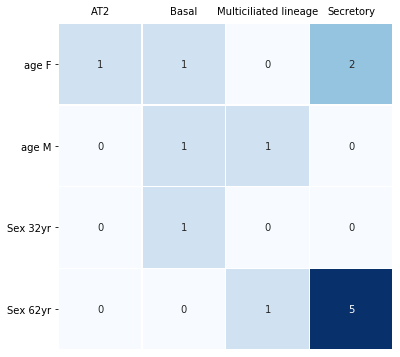

In [53]:
gene_mask = (res_summary_lvl3['gene'] == 'ACE2')
ct_mask = (res_summary_lvl3['cell_identity'].isin(['AT2', 'Basal', 'Multiciliated lineage', 'Secretory']))

ace2_holdout_res = res_summary_lvl3.loc[(gene_mask & ct_mask)][[('holdout_dataset_dis',''), ('covariate',''), ('cell_identity',''), ('eval_at','')]]
ace2_holdout_res['cov_eval'] = [' '.join([i1, i2]) for i1,i2 in zip(ace2_holdout_res[('covariate','')], ace2_holdout_res[('eval_at','')])]
ace2_holdout_res = ace2_holdout_res.pivot(index='cov_eval', columns='cell_identity')
ace2_holdout_res = ace2_holdout_res.drop(columns=['eval_at', 'covariate'])

ace2_holdout_res.columns = ace2_holdout_res.columns.get_level_values(2)
ace2_holdout_res.index = [item.replace('sex[T.male]', 'Sex').replace('smoking_status[T.True]', 'Smoking status') for item in ace2_holdout_res.index.tolist()]

rcParams['figure.figsize'] = (6,6)
p1 = sns.heatmap(ace2_holdout_res, cbar=False, cmap='Blues', annot=True, linewidths=.5)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
p1.set_yticklabels(ace2_holdout_res.index, rotation=0)
plt.ylabel('')
plt.xlabel('')
plt.savefig(folder+'/'+output_folder+de_output_base+'_annlvl3_ace2_dataset_disagreements.pdf', dpi=300, bbox_inches='tight')
plt.show()
rcParams['figure.figsize'] = (8,8)

/home/icb/malte.luecken/anaconda3/envs/cov19_py/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


[Text(0, 0.5, 'age F'),
 Text(0, 1.5, 'age M'),
 Text(0, 2.5, 'Sex 32yr'),
 Text(0, 3.5, 'Sex 62yr')]

Text(5.9999999999999964, 0.5, '')

Text(0.5, 33.0, '')

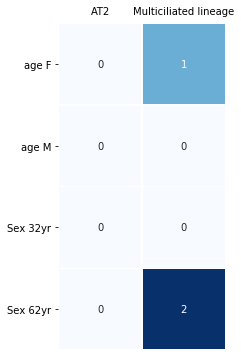

In [54]:
gene_mask = (res_summary_lvl3['gene'] == 'TMPRSS2')
ct_mask = (res_summary_lvl3['cell_identity'].isin(['AT2', 'Multiciliated lineage']))

tmprss2_holdout_res = res_summary_lvl3.loc[(gene_mask & ct_mask)][[('holdout_dataset_dis',''), ('covariate',''), ('cell_identity',''), ('eval_at','')]]
tmprss2_holdout_res['cov_eval'] = [' '.join([i1, i2]) for i1,i2 in zip(tmprss2_holdout_res[('covariate','')], tmprss2_holdout_res[('eval_at','')])]
tmprss2_holdout_res = tmprss2_holdout_res.pivot(index='cov_eval', columns='cell_identity')
tmprss2_holdout_res = tmprss2_holdout_res.drop(columns=['eval_at', 'covariate'])

tmprss2_holdout_res.columns = tmprss2_holdout_res.columns.get_level_values(2)
tmprss2_holdout_res.index = [item.replace('sex[T.male]', 'Sex').replace('smoking_status[T.True]', 'Smoking status') for item in tmprss2_holdout_res.index.tolist()]

rcParams['figure.figsize'] = (3,6)
p1 = sns.heatmap(tmprss2_holdout_res, cbar=False, cmap='Blues', annot=True, linewidths=.5)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
p1.set_yticklabels(tmprss2_holdout_res.index, rotation=0)
plt.ylabel('')
plt.xlabel('')
plt.savefig(folder+'/'+output_folder+de_output_base+'_annlvl3_tmprss2_dataset_disagreements.pdf', dpi=300, bbox_inches='tight')
plt.show()
rcParams['figure.figsize'] = (8,8)

/home/icb/malte.luecken/anaconda3/envs/cov19_py/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


[Text(0, 0.5, 'age F'),
 Text(0, 1.5, 'age M'),
 Text(0, 2.5, 'Sex 32yr'),
 Text(0, 3.5, 'Sex 62yr')]

Text(5.9999999999999964, 0.5, '')

Text(0.5, 33.0, '')

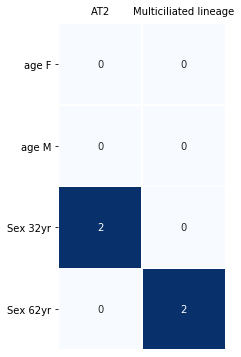

In [55]:
gene_mask = (res_summary_lvl3['gene'] == 'CTSL')
ct_mask = (res_summary_lvl3['cell_identity'].isin(['AT2', 'Multiciliated lineage']))

ctsl_holdout_res = res_summary_lvl3.loc[(gene_mask & ct_mask)][[('holdout_dataset_dis',''), ('covariate',''), ('cell_identity',''), ('eval_at','')]]
ctsl_holdout_res['cov_eval'] = [' '.join([i1, i2]) for i1,i2 in zip(ctsl_holdout_res[('covariate','')], ctsl_holdout_res[('eval_at','')])]
ctsl_holdout_res = ctsl_holdout_res.pivot(index='cov_eval', columns='cell_identity')
ctsl_holdout_res = ctsl_holdout_res.drop(columns=['eval_at', 'covariate'])

ctsl_holdout_res.columns = ctsl_holdout_res.columns.get_level_values(2)
ctsl_holdout_res.index = [item.replace('sex[T.male]', 'Sex').replace('smoking_status[T.True]', 'Smoking status') for item in ctsl_holdout_res.index.tolist()]

rcParams['figure.figsize'] = (3,6)
p1 = sns.heatmap(ctsl_holdout_res, cbar=False, cmap='Blues', annot=True, linewidths=.5)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
p1.set_yticklabels(ctsl_holdout_res.index, rotation=0)
plt.ylabel('')
plt.xlabel('')
plt.savefig(folder+'/'+output_folder+de_output_base+'_annlvl3_ctsl_dataset_disagreements.pdf', dpi=300, bbox_inches='tight')
plt.show()
rcParams['figure.figsize'] = (8,8)

# Store results

In [56]:
res_summary_lvl2.columns = ['_'.join(col).strip('_') for col in res_summary_lvl2.columns.values]
res_summary_lvl3.columns = ['_'.join(col).strip('_') for col in res_summary_lvl3.columns.values]

In [57]:
res_summary_lvl2.to_csv(folder+'/'+output_folder+de_output_base+'_lvl2_summary.csv')
full_res_lvl2_glm.to_csv(folder+'/'+output_folder+de_output_base+'_lvl2_full.csv')

In [58]:
res_summary_lvl3.to_csv(folder+'/'+output_folder+de_output_base+'_lvl3_summary.csv')
full_res_lvl3_glm.to_csv(folder+'/'+output_folder+de_output_base+'_lvl3_full.csv')